# Decision tree regression learning

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
from IPython.display import display, SVG, Image
from graphviz import Source

import ipywidgets as widgets

np.random.seed(0)

In [2]:
xmin = 0.01
xmax = 1
xres = 100
plot_res = 10000

x = np.linspace(xmin, xmax, xres)
x_plot = np.linspace(xmin, xmax, plot_res)
y = np.polynomial.polynomial.polyval(x, [0, 2, 5]) + np.sin(10*x) + 0.2 * np.random.normal(size=xres)

depth_max = 20

In [3]:
def classify(depth):
    return DecisionTreeRegressor(max_depth=depth, random_state=1).fit(x.reshape(-1, 1), y)

# from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def parse_tree(dtree):
    n_nodes = dtree.tree_.node_count
    children_left = dtree.tree_.children_left
    children_right = dtree.tree_.children_right
    feature = dtree.tree_.feature
    threshold = dtree.tree_.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    return (n_nodes, node_depth, is_leaves, children_left, children_right, feature, threshold)

def get_splits(dtree):
    n_nodes, node_depth, is_leaves, children_left, children_right, feature, threshold = parse_tree(dtree)
    result = []
    for i in range(n_nodes):
        if not is_leaves[i]:
            result.append([node_depth[i], threshold[i]])
    return(np.array(result))

In [4]:
y_predicted_saves = np.zeros((depth_max, plot_res))
tree_saves = [None] * depth_max
split_saves = [None] * depth_max
image_saves = [None] * depth_max
loss_computed_saves = np.zeros(depth_max)

for save_step in range(0, depth_max):
    model = classify(save_step+1)
    tree_saves[save_step] = model
    y_predicted_saves[save_step] = model.predict(x_plot.reshape(-1, 1))
    loss_computed_saves[save_step] = mean_squared_error(y, model.predict(x.reshape(-1, 1)))
    split_saves[save_step] = get_splits(model)
    #image_saves[save_step] = Source(export_graphviz(model, out_file=None, filled = True, rounded=True))
    image_saves[save_step] = Image(Source(export_graphviz(model, out_file=None, filled = True, rounded=True)).pipe(format='png'))

## Plots

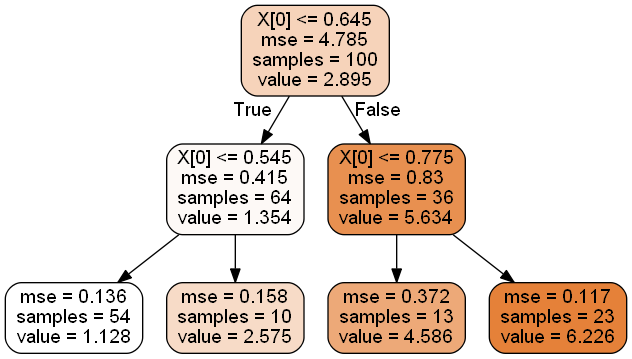

In [5]:
display(image_saves[1])

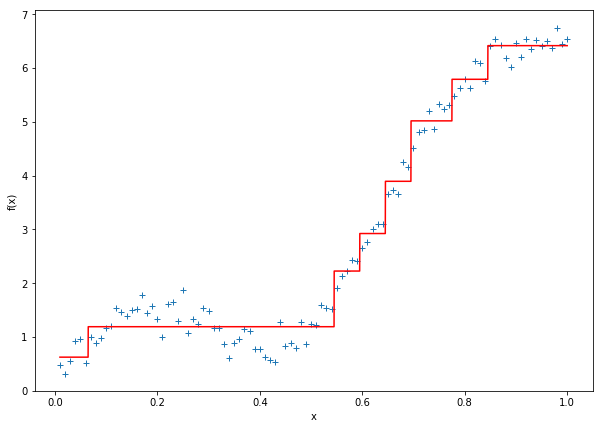

In [6]:
fig = plt.figure(figsize=(10,7))
plt.plot(x, y, '+', x_plot, y_predicted_saves[2], 'r')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

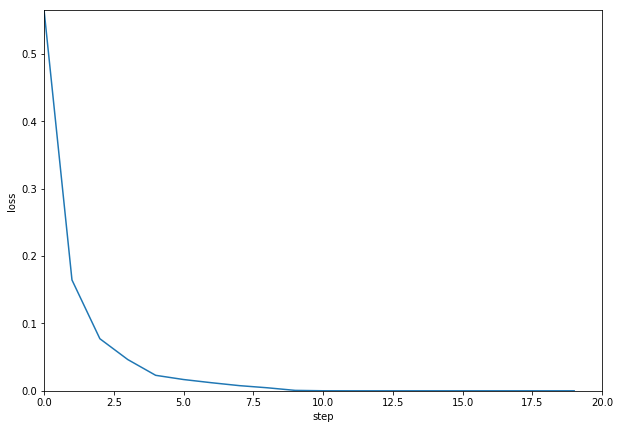

In [7]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(0, depth_max), loss_computed_saves)
plt.xlabel('step')
plt.ylabel('loss')
plt.xlim((0, depth_max))
plt.ylim((0, np.max(loss_computed_saves)))
plt.show()

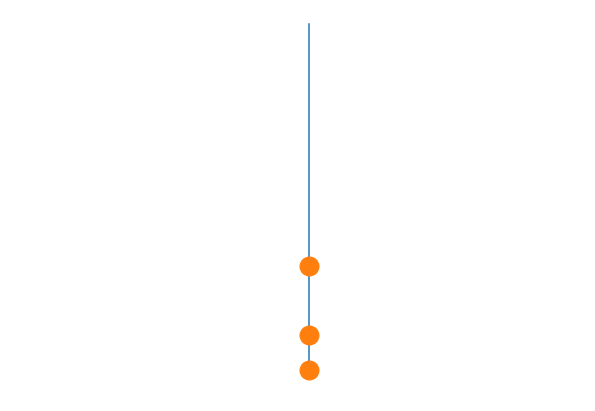

In [8]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.axis('off')

plt.plot([0, 0], [1, 0])
plt.plot([0, 0, 0], [0,.1,.3], 'o', markersize=19)

plt.show()

## Play widget

In [9]:
ymin, ymax = np.min(y_predicted_saves), np.max(y_predicted_saves)
 
plot_output = widgets.Output()
tree_output = widgets.Output()

rmse_output = widgets.HTML()
rmse_progress = widgets.FloatProgress(
    min=0,
    max=1.0,
    step=0.01,
    description='Cost :',
    bar_style='info',
    orientation='horizontal'
)
rmse_ui = widgets.HBox([rmse_progress, rmse_output], layout={'margin':'10px 10px 10px 10px'})

depth_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=depth_max,
    description='Tree depth :')
depth_ui = widgets.HBox([depth_slider], layout={'margin':'10px 10px 10px 10px'})

ui = widgets.VBox([plot_output, rmse_ui, tree_output, depth_ui], layout={'border':'1px solid black'})

def update_plot(ev):
    plot_output.clear_output(wait=True)
    with plot_output:
        fig = plt.figure(figsize=(10,7))
        plt.plot(x, y, '+', x_plot, y_predicted_saves[depth_slider.value - 1], 'r')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.ylim((ymin, ymax))
        plt.show()
        
        rmse_output.value = str(loss_computed_saves[depth_slider.value - 1])
        rmse_progress.value = loss_computed_saves[depth_slider.value - 1]
        
    tree_output.clear_output(wait=True)
    with tree_output:
        display(image_saves[depth_slider.value - 1])

        
depth_slider.observe(update_plot, names='value')
# initialize widget
update_plot(None) 

display(ui)